Optuna example that optimizes a neural network classifier configuration for the digit dataset using Keras.

In [248]:
import optuna

Import more useful libraries

In [249]:
import pickle
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# machine learning basics
# train_test_split was moved from cross_validation to model_selection in 0.18
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [250]:
BATCHSIZE = 500
# number of epochs
EPOCHS = 20

# needed to save best model so far
global best_accuracy_so_far

## The objective function for optuna to optimize the hyperparameters

In [251]:
def objective(trial):
    global best_accuracy_so_far

    # Clear clutter from previous Keras session graphs.
    clear_session()

    trees = pd.read_csv('../train.csv', header=0, index_col="Id")

    # get features X and labels y
    X = trees.values[:,:-1]
    y = trees["Cover_Type"]
    # split dataset into training and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(X, y)

    scaler = StandardScaler()
    # Fit only to the training data
    scaler.fit(X_train)
    # save fitted scaler, because you need it later for the test dataset
    pickle.dump(scaler, open("scaler.p", "wb"))

    # Now apply the transformations to the data:
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)

    # create neural network
    model = Sequential()

    model.add(Input(shape=54))
    model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=trial.suggest_int("units", 12, 36, step=4), kernel_initializer='uniform',
                    activation=trial.suggest_categorical("activation", ["relu", "linear"])))
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate=trial.suggest_float("rate", 0.0, 0.1, step=0.1)))
    model.add(Dense(14, kernel_initializer='uniform', activation='sigmoid'))

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    # train neural network
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_val, y_val, verbose=0)

    # save best model so far to be able to use the best model later to predict with test data
    if score[1] >= best_accuracy_so_far:
        tf.keras.models.save_model(model, '{0}.mdl'.format(trial.number))
        best_accuracy_so_far = score[1]

    # return accuracy
    return score[1]

# Main Function

Use optuna to do hyperparameter optimization to find optimal neural network architecture

In [252]:
best_accuracy_so_far = -100
study = optuna.create_study(direction="maximize")
# be cautious with the number of trials: Do not use a number larger than 50
# this call starts the hyperparameter optimization process: the above define function "objective" is called with
# n_trials different hyperparameter combinations
study.optimize(objective, n_trials=10, timeout=600)

[I 2022-12-03 20:53:00,572] A new study created in memory with name: no-name-eb2dbc25-8ea9-4e0b-a15f-ea6a36327b13


INFO:tensorflow:Assets written to: 0.mdl\assets


INFO:tensorflow:Assets written to: 0.mdl\assets
[I 2022-12-03 20:53:07,898] Trial 0 finished with value: 0.3137566149234772 and parameters: {'units': 12, 'activation': 'linear', 'rate': 0.1, 'learning_rate': 0.0001335772036468108}. Best is trial 0 with value: 0.3137566149234772.


INFO:tensorflow:Assets written to: 1.mdl\assets


INFO:tensorflow:Assets written to: 1.mdl\assets
[I 2022-12-03 20:53:14,892] Trial 1 finished with value: 0.3253968358039856 and parameters: {'units': 20, 'activation': 'relu', 'rate': 0.1, 'learning_rate': 2.1701392586104522e-05}. Best is trial 1 with value: 0.3253968358039856.


INFO:tensorflow:Assets written to: 2.mdl\assets


INFO:tensorflow:Assets written to: 2.mdl\assets
[I 2022-12-03 20:53:21,362] Trial 2 finished with value: 0.7269841432571411 and parameters: {'units': 36, 'activation': 'relu', 'rate': 0.0, 'learning_rate': 0.08694234993720028}. Best is trial 2 with value: 0.7269841432571411.


INFO:tensorflow:Assets written to: 3.mdl\assets


INFO:tensorflow:Assets written to: 3.mdl\assets
[I 2022-12-03 20:53:28,165] Trial 3 finished with value: 0.7563492059707642 and parameters: {'units': 12, 'activation': 'linear', 'rate': 0.1, 'learning_rate': 0.018305710402239397}. Best is trial 3 with value: 0.7563492059707642.
[I 2022-12-03 20:53:33,974] Trial 4 finished with value: 0.7423280477523804 and parameters: {'units': 20, 'activation': 'relu', 'rate': 0.1, 'learning_rate': 0.01435777293881825}. Best is trial 3 with value: 0.7563492059707642.
[I 2022-12-03 20:53:38,411] Trial 5 finished with value: 0.7362433671951294 and parameters: {'units': 24, 'activation': 'relu', 'rate': 0.1, 'learning_rate': 0.055627567623185194}. Best is trial 3 with value: 0.7563492059707642.
[I 2022-12-03 20:53:42,974] Trial 6 finished with value: 0.29100528359413147 and parameters: {'units': 24, 'activation': 'linear', 'rate': 0.0, 'learning_rate': 0.0001214554396590046}. Best is trial 3 with value: 0.7563492059707642.
[I 2022-12-03 20:53:48,692] Tri

Analyse the best model and use it to predict accuracy on test data

In [253]:
print("Best trial:")
trial = study.best_trial
print(trial)

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
FrozenTrial(number=3, values=[0.7563492059707642], datetime_start=datetime.datetime(2022, 12, 3, 20, 53, 21, 364680), datetime_complete=datetime.datetime(2022, 12, 3, 20, 53, 28, 165352), params={'units': 12, 'activation': 'linear', 'rate': 0.1, 'learning_rate': 0.018305710402239397}, distributions={'units': IntDistribution(high=36, log=False, low=12, step=4), 'activation': CategoricalDistribution(choices=('relu', 'linear')), 'rate': FloatDistribution(high=0.1, log=False, low=0.0, step=0.1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE, value=None)
  Value: 0.7563492059707642
  Params: 
    units: 12
    activation: linear
    rate: 0.1
    learning_rate: 0.018305710402239397


Load the best model. This model was saved in the function "objective".

In [254]:
best_model = tf.keras.models.load_model('{0}.mdl'.format(trial.number))

### Return performance of final model on new data (test data)
TODO: only load test data here, that you get a few days before the deadline.

In [255]:
trees = pd.read_csv('../test_file.csv', header=0, index_col="Id")

X_test = trees.values[:,:-1]
y_test = trees["Cover_Type"]

scaler = pickle.load(open("scaler.p", "rb"))
# important: preprocessing of test dataset has to be the same as for the training dataset
X_test = scaler.transform(X_test)

Predicting the Test set results

In [256]:
y_pred = best_model.predict(X_test)
print(y_pred)
# create labels out of predictions
y_pred_labels = np.argmax(y_pred, axis=1)

17685/17685 [==============================] - 33s 2ms/step
[[2.7047450e-04 9.9662364e-01 9.9920952e-01 ... 2.6063382e-04
  2.9149622e-04 4.0029504e-04]
 [2.8024304e-05 9.9938846e-01 9.9990118e-01 ... 2.7185459e-05
  3.0548956e-05 5.1634383e-05]
 [1.4249042e-04 9.9921095e-01 9.9977535e-01 ... 1.4135124e-04
  1.5833881e-04 2.3657977e-04]
 ...
 [1.3921043e-07 8.6467808e-01 9.9592072e-01 ... 1.0304436e-07
  1.0250469e-07 2.3614859e-07]
 [1.6829209e-07 8.8543272e-01 9.9640918e-01 ... 1.2665393e-07
  1.2714467e-07 2.8852165e-07]
 [1.9767644e-07 8.9508742e-01 9.9646693e-01 ... 1.4942607e-07
  1.5084872e-07 3.3656659e-07]]


Making the Confusion Matrix

In [257]:
cm = confusion_matrix(y_test, y_pred_labels)

print("Our accuracy is {}%".format(((cm[0][0] + cm[1][1]) / cm.sum()) * 100))

Our accuracy is 52.3983374919596%


Plot heatmap

              precision    recall  f1-score   support

           1       0.65      0.61      0.63    209680
           2       0.72      0.60      0.66    281141
           3       0.72      0.67      0.69     33594
           4       0.18      0.93      0.30       587
           5       0.11      0.86      0.20      7333
           6       0.35      0.73      0.47     15207
           7       0.29      0.25      0.27     18350

    accuracy                           0.60    565892
   macro avg       0.43      0.66      0.46    565892
weighted avg       0.66      0.60      0.62    565892



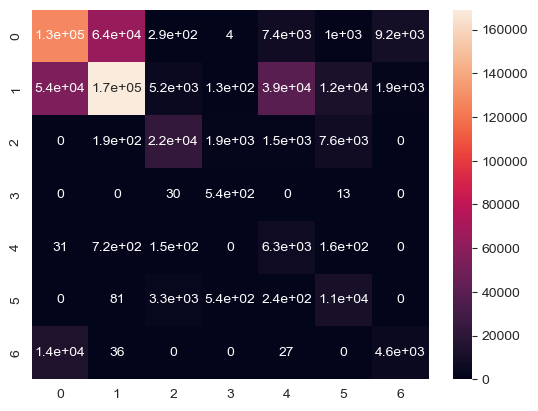

In [258]:
sns.heatmap(cm, annot=True)
plt.savefig('confmat.png')

print(classification_report(y_test, y_pred_labels))